In [1]:
from osmnx.graph import graph_from_place
import osmnx as ox

In [2]:
G = graph_from_place("Paderborn")

In [3]:
nodes, edges = ox.graph_to_gdfs(G)

In [4]:
import re

In [5]:
def extract_name(street_name):
    pattern = "([a-zA-Z]*)-([a-zA-Z]*)-.*"
    try:
        match = re.match(pattern, street_name)
    except TypeError:
        print(street_name)
    try:
        return ((match.group(1), match.group(2)), street_name)
    except:
        return street_name

In [6]:
gendered_street_names = set(
    [x for x in map(
                    extract_name, set(
                                    [x for x in edges["name"].to_list() if isinstance(x,str)]
                                    )
                    ) if isinstance(x, tuple)
    ]
)

In [7]:
from dotenv import dotenv_values
env = dotenv_values()

In [8]:
from requests import get
import time

In [9]:
HEADERS = {
    "accept": "application/json",
    "X-API-KEY": env["apikey"]
}

In [10]:
gender_detected = []
for (first_name, last_name), street_name in gendered_street_names:
    base = f"https://v2.namsor.com/NamSorAPIv2/api2/json/genderGeo/{first_name}/{last_name}/DE"
    r = get(base, headers=HEADERS).json()
    gender = r["likelyGender"]
    p = r["probabilityCalibrated"]
    gender_detected.append((street_name, gender, p))
    time.sleep(1)

In [11]:
filtered = [x for x in gender_detected if x[2]>=0.9]

In [12]:
import pandas as pd

In [13]:
gender_df = pd.DataFrame(filtered, columns=["street_name", "gender", "p"])

In [14]:
edges["name"] = edges["name"].astype(str)
gender_df["street_name"] = gender_df["street_name"].astype(str)
merged_df = edges\
    .rename(columns={"name":"street_name"})\
    .merge(gender_df, on="street_name")

In [15]:
from matplotlib import pyplot as plt

<AxesSubplot:>

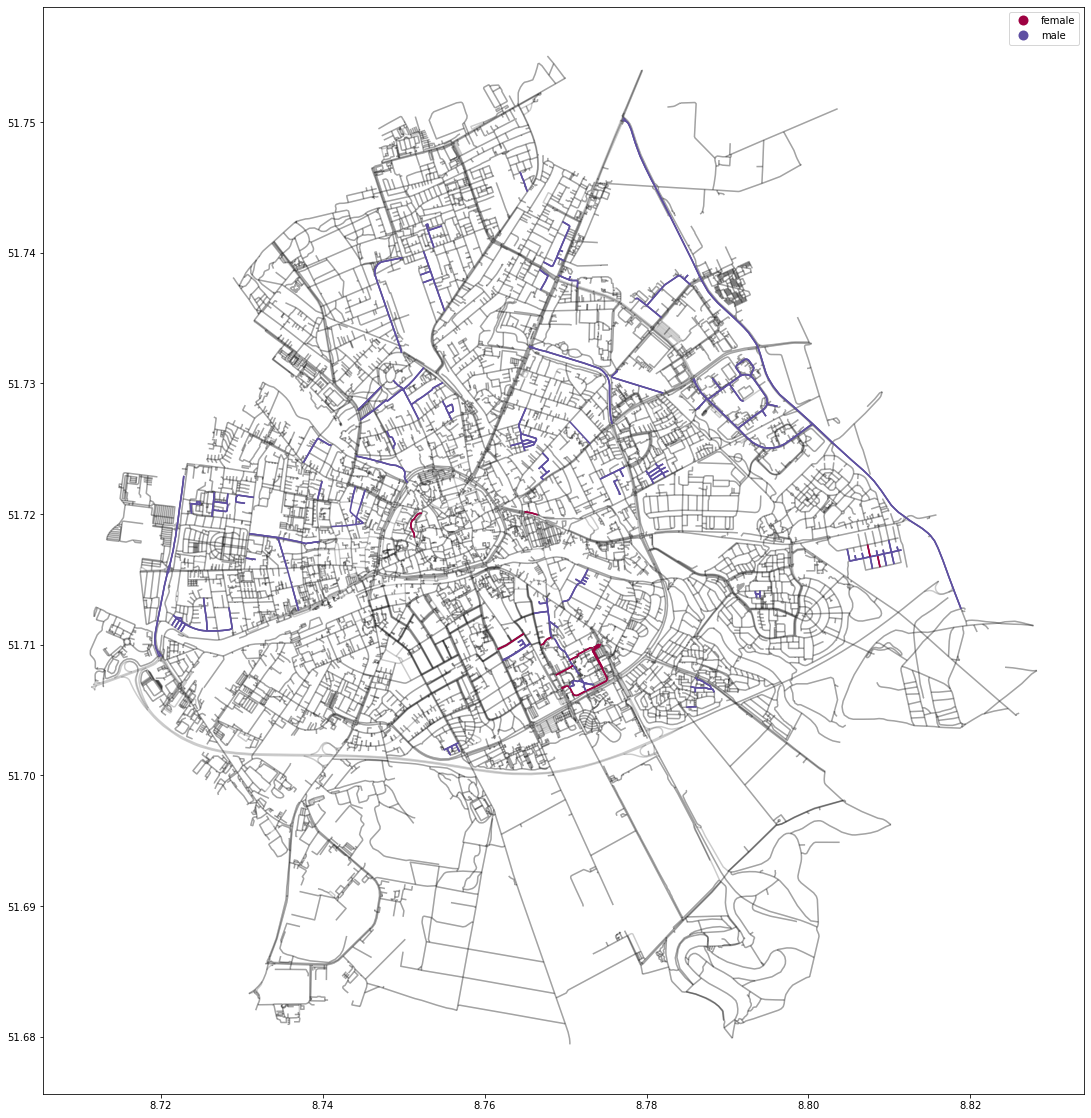

In [16]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
MARKERSIZE=1
edges.plot(ax=ax, alpha=0.2, markersize=MARKERSIZE, edgecolor="black")
merged_df.plot(column="gender", ax=ax, markersize=MARKERSIZE, legend=True, cmap='Spectral')

In [17]:
def streets_per_gender(df):
    res = {}
    for gender in ["male", "female"]:
        res[gender] = {}
        d = df.loc[df["gender"]==gender]
        res[gender]["number_of_streets"] = len(d.groupby("street_name")["street_name"].count().index)
        res[gender]["length_of_streets_km"] = round(sum([a["length"] for i,a in d.iterrows()])/1000,2)
    return res

In [18]:
descr = streets_per_gender(merged_df)

In [19]:
print("Durchschnittliche Länge der Straßen:")
for gender in descr:
    print(gender + ": " + str(descr[gender]["length_of_streets_km"]/descr[gender]["number_of_streets"]))

Durchschnittliche Länge der Straßen:
male: 1.0755172413793104
female: 0.63625


In [24]:
descr

{'male': {'number_of_streets': 58, 'length_of_streets_km': 62.38},
 'female': {'number_of_streets': 8, 'length_of_streets_km': 5.09}}

In [32]:
for gender in descr:
    print(f"{round(descr[gender]['number_of_streets']/len(set(edges['name'])),2)}")

0.08
0.01
